In [3]:
import gym

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math
import random
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from scipy.stats import multivariate_normal
from sklearn import linear_model
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm
from matplotlib.colors import LogNorm
import pickle

from joblib import Parallel, delayed
import multiprocessing
from collections import namedtuple
from itertools import count

import cProfile
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

from tqdm import tqdm

/home/atta/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [5]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3

In [6]:
class TicTacToe(gym.Env):
    def __init__(self, n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.n_win = n_win

        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.gameOver = False
        self.boardHash = None
        # ход первого игрока
        self.curTurn = 1
        self.emptySpaces = None
        
        self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([ (i, j) for i,j in zip(res[0], res[1]) ])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_marks, cur_p = np.where(self.board == self.curTurn), self.curTurn
        for i,j in zip(cur_marks[0], cur_marks[1]):
#             print((i,j))
            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(self.board[i,j:j+self.n_win] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                    if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if win:
                self.gameOver = True
                return self.curTurn

        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----'*(self.n_cols)+'-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----'*(self.n_cols)+'-')

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return ( int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1

Для ускорения вычислений создан класс-наследник **TicTacToe**, в который внесены изменения, а именно:

- хеш теперь является не строкой, а числом
- добавлены методы генерации простых стратегий

In [7]:
class TicTacToeEx(TicTacToe):
    def __init__(self, n_rows = N_ROWS, n_cols = N_COLS, n_win = N_WIN, rollout_copy = False):
        super().__init__(n_rows, n_cols, n_win)
        self.action_space_size = (3 ** (n_rows * n_cols), n_rows, n_cols) # состояние клетки
        self.end_state_cache = {}
        self.rollout_copy_env = None
        if not rollout_copy:
            self.rollout_copy_env = TicTacToeEx(n_rows, n_cols, n_win, True)
    
    def boardToHash(self, board):
        '''Преобразовать доску в хеш'''
        result = 0
        for x in board.reshape(self.n_rows * self.n_cols):
#             print(x)
            result = result * 3 + (x + 1)
        assert result < self.action_space_size[0]
        return result
    
    def hashToBoard(self, boardHash):
        '''Преобразовать хеш в доску'''
        result = np.zeros((self.n_rows, self.n_cols), dtype=int)
        col_index = self.n_cols - 1
        row_index = self.n_rows - 1
        v = boardHash
        for i in range(self.n_cols * self.n_rows):
            v_next = v // 3
            x = v % 3 - 1
            v = v_next
            result[row_index, col_index] = x
            col_index -= 1
            if col_index == -1:
                col_index = self.n_cols - 1
                row_index -= 1
        assert self.boardToHash(result) == boardHash
        return result
            
    def getHash(self):
        '''Упрощен расчет хеша, теперь хеш - число'''
        if self.boardHash is None:
            self.boardHash = self.boardToHash(self.board)
        return self.boardHash
    
    def isTerminal(self):
        '''метод медленный, поэтому добавлена мемоизация'''
        boardHash = self.getHash()
        if boardHash in self.end_state_cache:
            return self.end_state_cache[boardHash]
        value = super().isTerminal()
        self.end_state_cache[boardHash] = value
        return value
    
    def buildExplorationTabularPolicy(self):
        '''Построить равновероятную табулярную стратегию'''
        board = np.ones((self.n_rows, self.n_cols))
        board /= board.sum()
        result = []
        for v in range(self.action_space_size[0]):
            result.append(board)
        return np.array(result)
    
    def buildRandomTabularPolicy(self, board_hash):
        '''Построить равновероятную табулярную стратегию, избегать незаконных ходов'''
        board = self.hashToBoard(board_hash)
        for i in range(self.n_rows):
            for j in range(self.n_cols):
                x = board[i, j]
                board[i, j] = 1 if x == 0 else 0
        if board.sum() > 0:
            board = board / board.sum()
        else:
            print("something gone bad")
            print(board_hash)
            assert False
        return board
    
    def buildInitialQ(self, board_hash):
        '''Построить случайную начальную функцию Q'''
        board = self.hashToBoard(board_hash)
        for i in range(self.n_rows):
            for j in range(self.n_cols):
                x = board[i, j]
                board[i, j] = np.random.random() if x == 0 else -100
        return board
    
    def boardAsTensor(self):
        '''Текущая доска в виде тензора torch'''
        data = np.zeros((3, self.n_rows, self.n_cols))
        for i in range(self.n_rows):
            for j in range(self.n_cols):
                if self.board[i, j] == -1:
                    data[0, i, j] = 1
                elif self.board[i, j] == 1:
                    data[1, i, j] = 1
                else:
                    data[2, i, j] = 1
        return torch.from_numpy(data)
    
    def getRandomAction(self):
        return (random.randrange(0, self.n_rows), random.randrange(0, self.n_cols))
    
    def getRolloutEnv(self):
        '''Предполагаются rollouts в одном потоке'''
        self.rollout_copy_env.curTurn = env.curTurn
        self.rollout_copy_env.gameOver = self.gameOver
        self.rollout_copy_env.board = self.board.copy()
        self.rollout_copy_env.boardHash = None
        self.rollout_copy_env.emptySpaces = None
        return self.rollout_copy_env

**1.** Реализуйте обычное (табличное) Q-обучение. Обучите стратегии крестиков и ноликов для доски 3х3.

In [6]:
def play_game(env, Q_c, Q_n):
    env.reset()
    reward = 0
    done = False
    while not done:
        board_hash, emptySpaces, curTurn = env.getState()
        if curTurn == 1:
            if Q_c is not None and board_hash in Q_c:
                idx = np.argmax(Q_c[board_hash])
            else:
                idx = np.random.randint(len(emptySpaces))
            a = emptySpaces[idx]
            
        elif curTurn == -1:
            if Q_n is not None and board_hash in Q_n:
                idx = np.argmax(Q_n[board_hash])
            else:
                idx = np.random.randint(len(emptySpaces))
            a = emptySpaces[idx]
        _, reward, done, _ = env.step(a)
    return reward

def q_learning(env, episode_count = 200_000, alpha=0.01, epsilon=0.25, gamma=1.0, plot_history = True):
    Q_c = {}
    Q_n = {}
    x = []
    c_rewards = []
    n_rewards = []

    for i in tqdm(range(episode_count)):
        env.reset()
        done = False
        prev_board_hash_c = None
        prev_a_c = None
        prev_board_hash_n = None
        prev_a_n = None
        while not done:
            board_hash, emptySpaces, curTurn = env.getState()
            if curTurn == 1:
                if board_hash in Q_c and np.random.random() > epsilon:
                    idx = np.argmax(Q_c[board_hash])
                else:
                    idx = np.random.randint(len(emptySpaces))
                    if board_hash not in Q_c:
                        Q_c[board_hash] = np.zeros(len(emptySpaces))
                a = emptySpaces[idx]
                _, reward, done, _ = env.step(a)
                
                if prev_board_hash_n is not None:
                    board_hash_next = env.getHash()
                    q_max = np.max(Q_n[board_hash_next]) if board_hash_next in Q_n else 0
                    target = gamma * q_max - reward
                    Q_n[prev_board_hash_n][prev_a_n] += alpha * (target - Q_n[prev_board_hash_n][prev_a_n])
            
                if done:
                    target = reward
                    Q_c[board_hash][idx] += alpha * (target - Q_c[board_hash][idx])
                else:
                    prev_board_hash_c = board_hash
                    prev_a_c = idx
            else:
                if board_hash in Q_n and np.random.random() > epsilon:
                    idx = np.argmax(Q_n[board_hash])
                else:
                    idx = np.random.randint(len(emptySpaces))
                    if board_hash not in Q_n:
                        Q_n[board_hash] = np.zeros(len(emptySpaces))
                a = emptySpaces[idx]
                _, reward, done, _ = env.step(a)

                if prev_board_hash_c is not None:
                    board_hash_next = env.getHash()
                    q_max = np.max(Q_c[board_hash_next]) if board_hash_next in Q_c else 0
                    target = gamma * q_max + reward
                    Q_c[prev_board_hash_c][prev_a_c] += alpha * (target - Q_c[prev_board_hash_c][prev_a_c])

                if done:
                    target = -reward
                    Q_n[board_hash][idx] += alpha * (target - Q_n[board_hash][idx])
                else:
                    prev_board_hash_n = board_hash
                    prev_a_n = idx
        
        if plot_history and i % 10_000 == 0:
            reward = 0
            c_reward = 0
            n_reward = 0
            for _ in range(500):
                c_reward += play_game(env, Q_c, None)
                n_reward -= play_game(env, None, Q_n)
            c_reward /= 500
            n_reward /= 500
            x.append(i)
            c_rewards.append(c_reward)
            n_rewards.append(n_reward)

    if plot_history:
        x = np.array(x)
        c_rewards = np.array(c_rewards)
        n_rewards = np.array(n_rewards)
        plt.figure(figsize=(15, 5))
        plt.xlabel('Episode')
        plt.ylabel('Reward')
        plt.plot(x, c_rewards, label='x')
        plt.plot(x, n_rewards, label='o')
        plt.legend()
        plt.show()
    
    return Q_c, Q_n

**Все игры проводятся против случайной стратегии, которая не совершает нелегальных ходов**  
То есть "x" в легенде следует понимать как "крестики против случайной стратегии",  
а "о" как "нолики против случайной стратегии".

100%|██████████| 1000000/1000000 [04:25<00:00, 3772.62it/s]


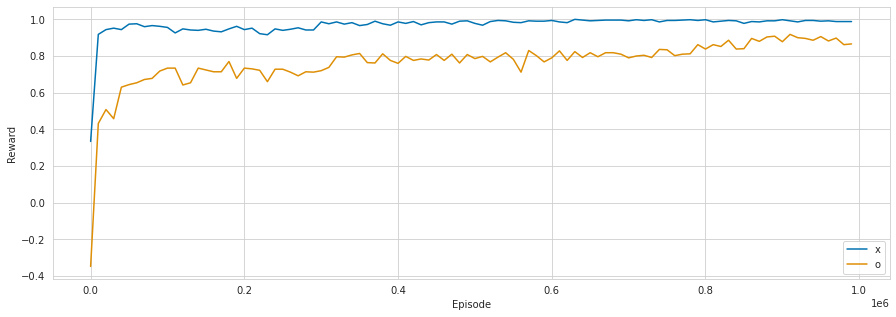

In [104]:
env = TicTacToeEx(3, 3, 3)
Q_c, Q_n = q_learning(env, episode_count = 1_000_000)


**2.** Попробуйте обучить стратегии крестиков и ноликов для доски 4х4 и/или 5х5.

100%|██████████| 25000000/25000000 [4:00:55<00:00, 1729.50it/s]  


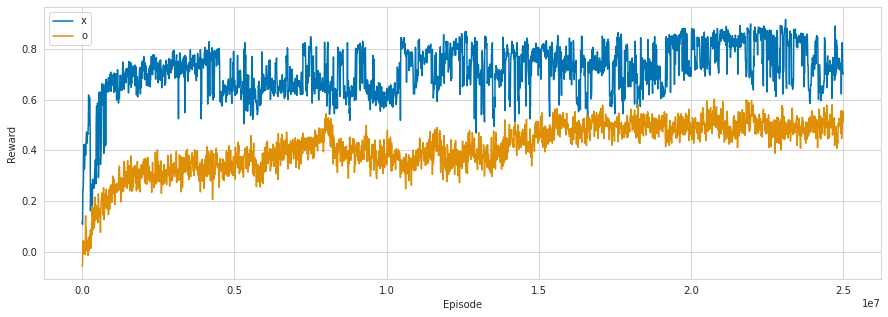

In [105]:
env = TicTacToeEx(4, 4, 4)
Q_c, Q_n = q_learning(env, episode_count = 25_000_000)

**3.** Реализуйте DQN с нейронной сетью, обучите стратегии крестиков и ноликов. 


In [7]:
def get_batch(moves, batch_size):
#     count = 0
#     i = 0
#     result = []
#     for move in moves:
#         if i < batch_size:
#             result.append(move)
#         elif random.randrange(0, i) < batch_size:
#             j = random.randrange(0, batch_size)
#             result[j] = move
#         i += 1
#     return result
    return random.sample(moves, batch_size)

def get_model_action(env, model, input_tensor):
    input_tensor = input_tensor.unsqueeze(0).to(device, dtype=torch.float)
#     print(input_tensor)
    with torch.no_grad():
        output = model(input_tensor)
#         print(output)
        result = output.data.max(1)[1].view(1, 1).cpu()
#     print(result)
        return env.action_from_int(result[0][0])

def play_dqn_game(env, Q_c, Q_n, verbose = False):
    env.reset()
    reward = 0
    done = False
    if verbose:
        print('/////////////////////')
    while not done:
        board_hash, emptySpaces, curTurn = env.getState()
        if curTurn == 1:
            if Q_c is not None:
                a = get_model_action(env, Q_c, env.boardAsTensor())
            else:
                idx = np.random.randint(len(emptySpaces))
                a = emptySpaces[idx]
        elif curTurn == -1:
            if Q_n is not None:
                a = get_model_action(env, Q_n, env.boardAsTensor())
            else:
                idx = np.random.randint(len(emptySpaces))
                a = emptySpaces[idx]
        if verbose:
            print(a)
        _, reward, done, _ = env.step(a)
        if verbose:
            env.printBoard()
        if curTurn == -1 and reward == -10:
            reward = 10
    if verbose:
        print(reward)
    return reward

def teach(model, optimizer, batch, gamma):

#     print(batch)
    # берём мини-батч из памяти
    batch_state, batch_action, batch_next_state, batch_reward = zip(*batch)

    batch_state = Variable(torch.stack(batch_state).to(device, dtype=torch.float))
    batch_action = Variable(torch.cat(batch_action).to(device))
    batch_reward = Variable(torch.cat(batch_reward).to(device, dtype=torch.float))
    batch_next_state = Variable(torch.stack(batch_next_state).to(device, dtype=torch.float))

    # считаем значения функции Q
    Q = model(batch_state)
#     print(batch_action.size())
    Q = Q.gather(1, batch_action)
    Q = Q.reshape(len(batch))

    # оцениваем ожидаемые значения после этого действия
    Qmax = model(batch_next_state).detach()
    Qmax = Qmax.max(1)[0]
    Qnext = batch_reward + (gamma * Qmax)
    # и хотим, чтобы Q было похоже на Qnext -- это и есть суть Q-обучения
    loss = F.smooth_l1_loss(Q, Qnext)
#     print(loss)
    optimizer.zero_grad()
    loss.backward()

    optimizer.step()


def store_move(moves, move, move_index, max_moves_stored):
    if len(moves) < max_moves_stored:
        moves.append(move)
    else:
        moves[move_index] = move
    return (move_index + 1) % max_moves_stored
                
def dqn_learning(env, Q_c, Q_n, optimizer_c, optimizer_n, teach_fn,
                 episode_count = 100_000, batch_size = 256, max_moves_stored = 500_000, 
                 epsilon=0.1, gamma=0.5, plot_history = True):
    moves_c_index = 0
    moves_n_index = 0
    moves_c = []
    moves_n = []
    
    x = []
    c_rewards = []
    n_rewards = []

    for i in tqdm(range(episode_count)):
        env.reset()
        done = False
        prev_board_tensor_c = None
        prev_a_c = None
        prev_board_tensor_n = None
        prev_a_n = None
        while not done:
            board_hash, emptySpaces, curTurn = env.getState()
            board_tensor = env.boardAsTensor()
            if curTurn == 1:
                # выбор действия крестиков
                if np.random.random() > epsilon:
                    a = get_model_action(env, Q_c, board_tensor)
                else:
                    a = env.getRandomAction()
                _, reward, done, _ = env.step(a)
                next_board_tensor = env.boardAsTensor()

                if prev_board_tensor_n is not None:
                    # сохранить прошлый ход ноликов
                    move = (prev_board_tensor_n, torch.tensor([[env.int_from_action(prev_a_n)]]),
                            next_board_tensor, torch.tensor([0 if reward == -10 else -reward]))
                    moves_n_index = store_move(moves_n, move, moves_n_index, max_moves_stored)
            
                if done:
                    # сохранить текущий ход крестиков, если они выиграли
                    move = (board_tensor, torch.tensor([[env.int_from_action(a)]]),
                            next_board_tensor, torch.tensor([reward]))
                    moves_c_index = store_move(moves_c, move, moves_c_index, max_moves_stored)
                else:
                    prev_board_tensor_c = board_tensor
                    prev_a_c = a
                if len(moves_c) > batch_size:
#                     print("x")
                    teach(Q_c, optimizer_c, get_batch(moves_c, batch_size), gamma)
                                
            else:
                # выбор действия ноликов
                if np.random.random() > epsilon:
                    a = get_model_action(env, Q_n, board_tensor)
                else:
                    a = env.getRandomAction()
                _, reward, done, _ = env.step(a)
                next_board_tensor = env.boardAsTensor()

                if prev_board_tensor_c is not None:
                    # сохранить прошлый ход крестиков
                    move = (prev_board_tensor_c, torch.tensor([[env.int_from_action(prev_a_c)]]),
                            next_board_tensor, torch.tensor([0 if reward == -10 else -reward]))
                    moves_c_index = store_move(moves_c, move, moves_c_index, max_moves_stored)

                if done:
                    # сохранить текущий ход ноликов, если они выиграли
                    move = (board_tensor, torch.tensor([[env.int_from_action(a)]]),
                            next_board_tensor, torch.tensor([reward if reward == -10 else -reward]))
                    moves_n_index = store_move(moves_n, move, moves_n_index, max_moves_stored)
                else:
                    prev_board_hash_n = board_hash
                    prev_a_n = a
                if len(moves_n) > batch_size:
#                     print("0")
                    teach(Q_n, optimizer_n, get_batch(moves_n, batch_size), gamma)
        
        if plot_history and i % 5_000 == 0:
            c_reward = 0
            n_reward = 0
            for _ in range(500):
                c_reward += play_dqn_game(env, Q_c, None)
                n_reward -= play_dqn_game(env, None, Q_n)
            c_reward /= 500
            n_reward /= 500
            x.append(i)
            c_rewards.append(c_reward)
            n_rewards.append(n_reward)

    if plot_history:
        x = np.array(x)
        c_rewards = np.array(c_rewards)
        n_rewards = np.array(n_rewards)
        plt.figure(figsize=(15, 5))
        plt.xlabel('Episode')
        plt.ylabel('Reward')
        plt.plot(x, c_rewards, label='x')
        plt.plot(x, n_rewards, label='o')
        plt.legend()
        plt.ylim((0.0, 1.0))
        plt.show()
    
    return Q_c, Q_n

**Игра 3x3**

100%|██████████| 100000/100000 [1:47:14<00:00, 16.67it/s]


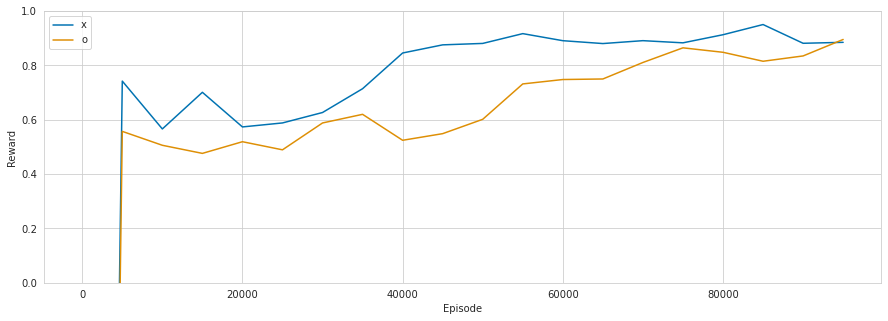

In [205]:
class Network(nn.Module):
    def __init__(self, conv_out=128):
        nn.Module.__init__(self)
        self.c1 = nn.Conv2d(3, conv_out * 2, (3, 3))
        self.l1 = nn.Linear(conv_out * 2, conv_out)
        self.l2 = nn.Linear(conv_out, 9)

    def forward(self, x):
        x = F.relu(self.c1(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.l1(x))
        x = self.l2(x)
        return x

env = TicTacToeEx(3, 3, 3)
Q_c = Network().to(device)
Q_n = Network().to(device)
optimizer_c = optim.AdamW(Q_n.parameters())
optimizer_n = optim.AdamW(Q_n.parameters())
Q_c, Q_n = dqn_learning(env, Q_c, Q_n, optimizer_c, optimizer_n, teach)

**Игра 4х4**

100%|██████████| 250000/250000 [3:58:44<00:00, 15.58it/s]


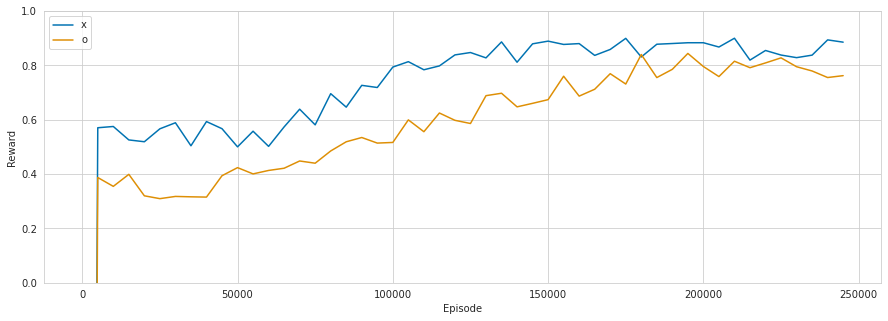

In [185]:
class Network(nn.Module):
    def __init__(self):
        nn.Module.__init__(self)
        self.c1 = nn.Conv2d(3, 16, (3, 3))
        self.c2 = nn.Conv2d(16, 256, (2, 2))
        self.l1 = nn.Linear(256, 128)
        self.l2 = nn.Linear(128, 16)

    def forward(self, x):
        x = F.relu(self.c1(x))
        x = F.relu(self.c2(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.l1(x))
        x = self.l2(x)
        return x

env = TicTacToeEx(4, 4, 4)
Q_c = Network().to(device)
Q_n = Network().to(device)
optimizer_c = optim.AdamW(Q_n.parameters())
optimizer_n = optim.AdamW(Q_n.parameters())
Q_c, Q_n = dqn_learning(env, Q_c, Q_n,  optimizer_c, optimizer_n, teach, episode_count = 250_000)

**4.** Реализуйте Double DQN и/или Dueling DQN.

In [8]:
stored_models = {}
            
def teach_double_dqn(model, optimizer, batch, gamma):

    # берём мини-батч из памяти
    batch_state, batch_action, batch_next_state, batch_reward = zip(*batch)
    
    model_hash = hash(model)
    if model_hash in stored_models:
        stored_model, counter = stored_models[model_hash]
    else:
        stored_model = type(model)().to(device)
        counter = 1

    batch_state = Variable(torch.stack(batch_state).to(device, dtype=torch.float))
    batch_action = Variable(torch.cat(batch_action).to(device))
    batch_reward = Variable(torch.cat(batch_reward).to(device, dtype=torch.float))
    batch_next_state = Variable(torch.stack(batch_next_state).to(device, dtype=torch.float))

    # считаем значения функции Q
    Q = model(batch_state)
    Q = Q.gather(1, batch_action)
    Q = Q.reshape(len(batch))

    # оцениваем ожидаемые значения после этого действия
    Qmax = stored_model(batch_next_state).detach()
    Qmax = Qmax.max(1)[0]
    Qnext = batch_reward + (gamma * Qmax)
    # и хотим, чтобы Q было похоже на Qnext -- это и есть суть Q-обучения
    loss = F.smooth_l1_loss(Q, Qnext)
    optimizer.zero_grad()
    loss.backward()

    optimizer.step()
    
    if counter % 500 == 0:
        stored_model.load_state_dict(model.state_dict())

**Double DQN 3x3**

100%|██████████| 100000/100000 [1:52:17<00:00, 17.36it/s]


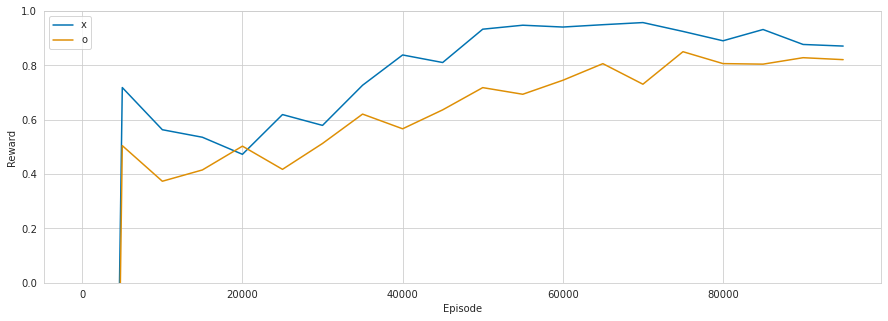

In [206]:
class Network(nn.Module):
    def __init__(self, conv_out=128):
        nn.Module.__init__(self)
        self.c1 = nn.Conv2d(3, conv_out * 2, (3, 3))
        self.l1 = nn.Linear(conv_out * 2, conv_out)
        self.l2 = nn.Linear(conv_out, 9)

    def forward(self, x):
        x = F.relu(self.c1(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.l1(x))
        x = self.l2(x)
        return x

env = TicTacToeEx(3, 3, 3)
Q_c = Network().to(device)
Q_n = Network().to(device)
optimizer_c = optim.AdamW(Q_n.parameters())
optimizer_n = optim.AdamW(Q_n.parameters())
Q_c, Q_n = dqn_learning(env, Q_c, Q_n, optimizer_c, optimizer_n, teach_double_dqn, episode_count = 100_000)

**Double DQN 4x4**

100%|██████████| 250000/250000 [4:43:55<00:00, 15.58it/s]


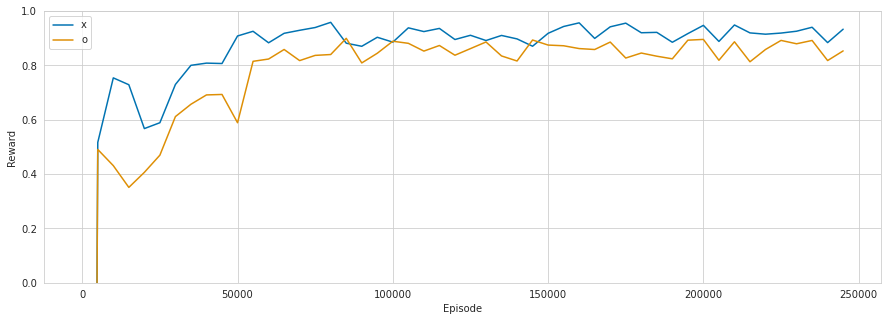

In [204]:
class Network(nn.Module):
    def __init__(self):
        nn.Module.__init__(self)
        self.c1 = nn.Conv2d(3, 16, (3, 3))
        self.c2 = nn.Conv2d(16, 256, (2, 2))
        self.l1 = nn.Linear(256, 128)
        self.l2 = nn.Linear(128, 16)

    def forward(self, x):
        x = F.relu(self.c1(x))
        x = F.relu(self.c2(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.l1(x))
        x = self.l2(x)
        return x

env = TicTacToeEx(4, 4, 4)
Q_c = Network().to(device)
Q_n = Network().to(device)
optimizer_c = optim.AdamW(Q_c.parameters())
optimizer_n = optim.AdamW(Q_n.parameters())
Q_c, Q_n = dqn_learning(env, Q_c, Q_n,  optimizer_c, optimizer_n, teach, episode_count = 250_000)

**Double dueling DQN 3x3**

100%|██████████| 100000/100000 [1:34:15<00:00, 18.99it/s]


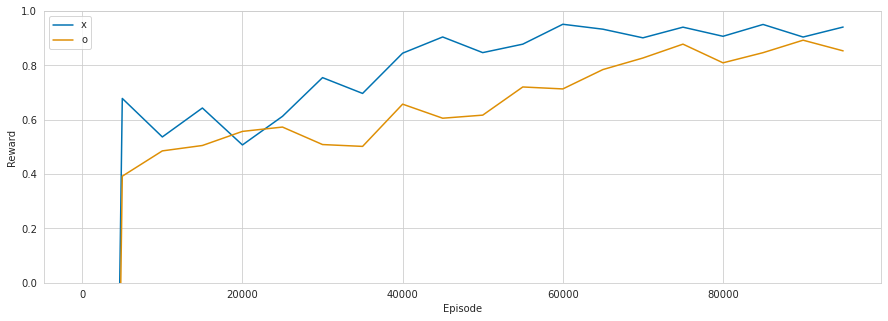

In [212]:
class Dueling_Network(nn.Module):
    def __init__(self, conv_out=128):
        nn.Module.__init__(self)
        self.c1 = nn.Conv2d(3, conv_out * 2, (3, 3))
        self.l1 = nn.Linear(conv_out * 2, conv_out)
        self.v = nn.Linear(conv_out, 1)
        self.a = nn.Linear(conv_out, 9)

    def forward(self, x):
        x = F.relu(self.c1(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.l1(x))
        v = self.v(x)
        a = self.a(x)
        x = v + (a - a.mean(dim=1, keepdim=True))
        return x
    
env = TicTacToeEx(3, 3, 3)
Q_c = Dueling_Network().to(device)
Q_n = Dueling_Network().to(device)
optimizer_c = optim.AdamW(Q_n.parameters())
optimizer_n = optim.AdamW(Q_n.parameters())
Q_c, Q_n = dqn_learning(env, Q_c, Q_n, optimizer_c, optimizer_n, teach_double_dqn, episode_count = 100_000)

**Double dueling DQN 5x5**

100%|██████████| 500000/500000 [13:21:39<00:00, 7.93it/s]


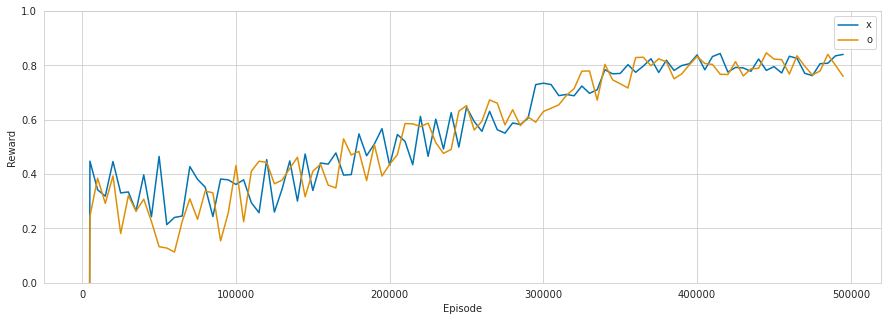

In [242]:
class Dueling_Network(nn.Module):
    def __init__(self):
        nn.Module.__init__(self)
        self.c1 = nn.Conv2d(3, 16, (3, 3))
        self.c2 = nn.Conv2d(16, 256, (3, 3))
        self.l1 = nn.Linear(256, 128)
        self.v = nn.Linear(128, 1)
        self.a = nn.Linear(128, 25)

    def forward(self, x):
        x = F.relu(self.c1(x))
        x = F.relu(self.c2(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.l1(x))
        v = self.v(x)
        a = self.a(x)
        x = v + (a - a.mean(dim=1, keepdim=True))
        return x
    
env = TicTacToeEx(5, 5, 5)
Q_c = Dueling_Network().to(device)
Q_n = Dueling_Network().to(device)
optimizer_c = optim.AdamW(Q_c.parameters())
optimizer_n = optim.AdamW(Q_n.parameters())
Q_c, Q_n = dqn_learning(env, Q_c, Q_n, optimizer_c, optimizer_n, teach_double_dqn, episode_count = 500_000)

**5.** Реализуйте rollouts со случайной стратегией и (опционально) rollouts с неслучайной, но простой стратегией (например, основанной на дополнении нескольких паттернов или на Q-функции, которая у вас получилась в первом пункте).

In [9]:
# стратегия UCB1 для многоруких бандитов

class UCB1():
    def __init__(self, action_space_size):
        self.size = action_space_size
        self.reward_sum = np.zeros(action_space_size)
        self.reward_count = np.zeros(action_space_size)
        self.metric = np.zeros(action_space_size)
        self.count = 0

    def get_action(self):
        if self.count < self.size:
            return self.count
        return np.argmax(self.metric)
    
    def update_action(self, action_idx, reward):
        self.reward_sum[action_idx] += reward
        self.reward_count[action_idx] += 1
        self.count += 1
        self.metric[action_idx] = self.reward_sum[action_idx] / self.reward_count[action_idx] \
            + np.sqrt(2 * np.log(self.count) / self.reward_count[action_idx])

In [10]:
# https://www.mit.edu/~dimitrib/Rollouts_Survey.pdf

def continue_game(env, Q_c, Q_n, start_action_idx):
    reward = 0
    done = False
    while not done:
        board_hash, emptySpaces, curTurn = env.getState()
        if curTurn == 1:
            if start_action_idx is not None:
                idx = start_action_idx
                start_action_idx = None
            elif Q_c is not None and board_hash in Q_c:
                idx = np.argmax(Q_c[board_hash])
            else:
                idx = np.random.randint(len(emptySpaces))
            a = emptySpaces[idx]
            
        elif curTurn == -1:
            if start_action_idx is not None:
                idx = start_action_idx
                start_action_idx = None
            elif Q_n is not None and board_hash in Q_n:
                idx = np.argmax(Q_n[board_hash])
            else:
                idx = np.random.randint(len(emptySpaces))
            a = emptySpaces[idx]
        _, reward, done, _ = env.step(a)
    if reward == -10 and env.curTurn == -1:
        reward = 10
    return reward

def play_rollout_game(env, Q_c, Q_n, rollouts_per_action):
    env.reset()
    reward = 0
    done = False
    while not done:
        board_hash, emptySpaces, curTurn = env.getState()
        if curTurn == 1:
            if Q_c is not None and rollouts_per_action > 0:
                action_space_size = len(emptySpaces)
                action_selector = UCB1(action_space_size)
                for i in range(action_space_size * rollouts_per_action):
                    idx = action_selector.get_action()
                    rollout_env = env.getRolloutEnv()
                    # rollout не против стратегии Q_n, это будет нечестно, а против случайной
                    rollout_reward = continue_game(rollout_env, Q_c, Q_n, idx)
                    action_selector.update_action(idx, rollout_reward)
                idx = action_selector.get_action()
            elif Q_c is not None and board_hash in Q_c:
                idx = np.argmax(Q_c[board_hash])
            else:
                idx = np.random.randint(len(emptySpaces))
            a = emptySpaces[idx]
            
        elif curTurn == -1:
            if Q_n is not None and rollouts_per_action > 0:
                action_space_size = len(emptySpaces)
                action_selector = UCB1(action_space_size)
                for i in range(action_space_size * rollouts_per_action):
                    idx = action_selector.get_action()
                    rollout_env = env.getRolloutEnv()
                    # rollout не против стратегии Q_с, это будет нечестно, а против случайной
                    rollout_reward = continue_game(rollout_env, Q_c, Q_n, idx)
                    action_selector.update_action(idx, -rollout_reward)
                idx = action_selector.get_action()
            elif Q_n is not None and board_hash in Q_n:
                idx = np.argmax(Q_n[board_hash])
            else:
                idx = np.random.randint(len(emptySpaces))
            a = emptySpaces[idx]
        _, reward, done, _ = env.step(a)
    return reward

In [11]:
def plot_rollout_factor(env, Q_c, Q_n, n_replays = 50, min_rollouts_per_action = 0, max_rollouts_per_action = 50):
    x = []
    c_wins = []
    n_wins = []
    draws = []
    for i in tqdm(range(min_rollouts_per_action, max_rollouts_per_action + 1)):
        c_win = 0
        n_win = 0
        draw = 0
        for j in range(n_replays):
            reward = play_rollout_game(env, Q_c, Q_n, i)
            if reward > 0:
                c_win += 1
            elif reward < 0:
                n_win += 1
            else:
                draw += 1
        x.append(i)
        c_wins.append(c_win / n_replays)
        n_wins.append(n_win / n_replays)
        draws.append(draw / n_replays)
    plt.figure(figsize=(15, 5))
    plt.xlabel('Rollouts per action choice')
    plt.ylabel('Share')
    plt.plot(x, c_wins, label='x win share')
    plt.plot(x, n_wins, label='o win share')
    plt.plot(x, draws, label='draw share')
    plt.legend()
    plt.ylim((0.0, 1.0))
    plt.show()

100%|██████████| 500000/500000 [05:30<00:00, 1513.67it/s]


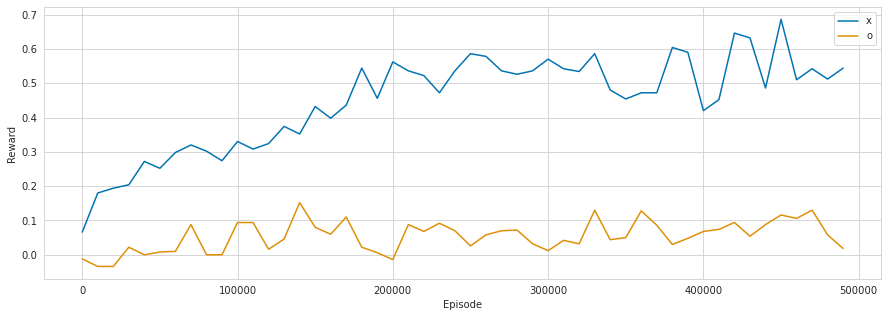

In [369]:
env = TicTacToeEx(4, 4, 4)

# частично обученные стратегии
Q_c, Q_n = q_learning(env, episode_count = 500_000, plot_history = True)

**Игры на поле 4х4, во время которых для выбора действия производятся rollouts**

100%|██████████| 51/51 [22:46<00:00, 26.78s/it]


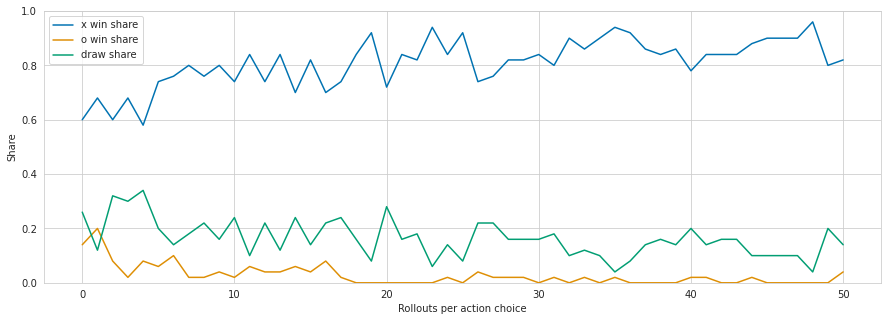

In [370]:
# недообученные крестики против случайной стратегии
plot_rollout_factor(env, Q_c, None)

100%|██████████| 51/51 [19:15<00:00, 22.65s/it]


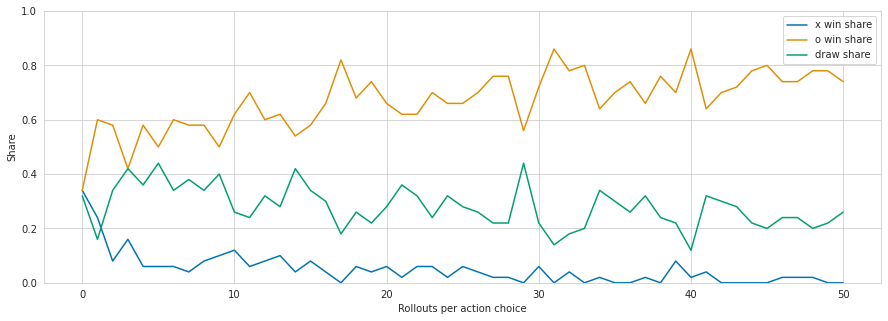

In [371]:
# недообученные нолики против случайной стратегии
plot_rollout_factor(env, None, Q_n)

100%|██████████| 51/51 [40:15<00:00, 47.36s/it]


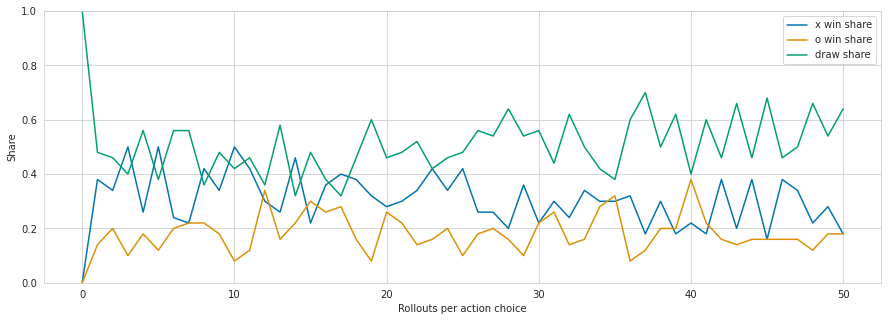

In [372]:
# крестики против ноликов, оба с rollout
plot_rollout_factor(env, Q_c, Q_n)

In [374]:
def generate_random_Q(env, Q):
    result = {}
    for board_hash, q in Q.items():
        result[board_hash] = np.random.random(q.shape)
    return result

# случайно выбранные детерминированные стратегии
Q_c_rand = generate_random_Q(env, Q_c)
Q_n_rand = generate_random_Q(env, Q_n)

100%|██████████| 51/51 [21:24<00:00, 25.19s/it]


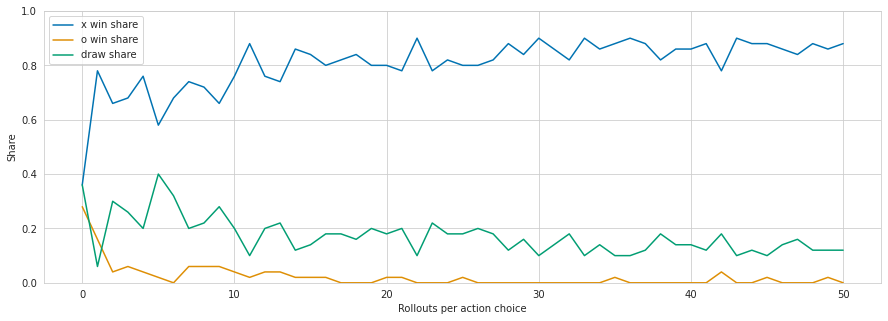

In [375]:
# случайно выбранные крестики против случайной стратегии
plot_rollout_factor(env, Q_c_rand, None)

100%|██████████| 51/51 [18:02<00:00, 21.23s/it]


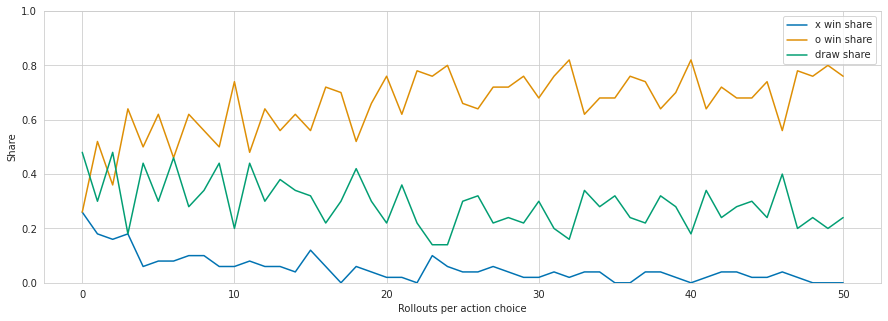

In [376]:
# случайно выбранные нолики против случайной стратегии
plot_rollout_factor(env, None, Q_n_rand)

100%|██████████| 51/51 [40:05<00:00, 47.17s/it]


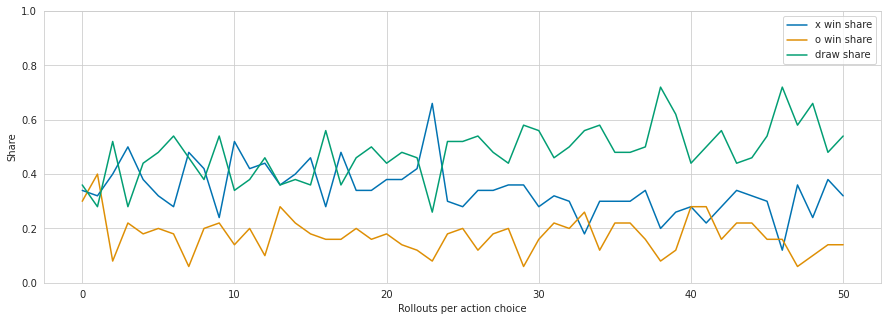

In [377]:
# случайно выбранные крестики против случайно выбранных ноликов, оба с rollout
plot_rollout_factor(env, Q_c_rand, Q_n_rand)

Выводы:

- rollout радикально улучшает плохие стратегии
- rollout улучшил случайную стратегию до уровня обученной стратегии (не знаю, насколько это обобщаемо)
- если обе антагонистичные стратегии играют с rollout, то число ничьих повышается, а сила игры стратегий сравнивается

**6.** Реализуйте MCTS-поиск с этими rollouts для крестиков-ноликов на досках разного размера, сравните полученные стратегии между собой и со стратегиями, обученными в первых двух частях.

В алгоритм MCTS внесены следующие изменения:

- вместо просто очка за победу начисляется 2 очка за победу и очко зн ничью; это нужно, чтобы ничья отличилась от поражения
- вместо учета побед и чиста игр для узла эти характеристики общие между узлами дерева, соответствующих одинаковым позициям, благодаря этому exploitation учитывается в формуле UCT по большему числу игр
- чтобы проверить, что получилось, из дерева строится табличная жадная стратегия, по ней и производятся контрольные игры против случайной стратегии

In [8]:
# узел дерева MCTS

class UCTNodeCached():
    def __init__(self, parent_node, cur_turn, game_over, board, board_hash, state_cache, c = 50):
        self.parent_node = parent_node
        self.children = None
        self.cur_turn = cur_turn
        self.game_over = game_over
        self.board = board.copy()
        self.board_hash = board_hash
        self.state_cache = state_cache
        self.state_key = (cur_turn, board_hash)
        if self.state_key not in state_cache:
            state_cache[self.state_key] = (0, 0)
        self.count = 0
        self.c = c
        
    def get_reward_sum(self):
        return self.state_cache[self.state_key][0]
    
    
    def get_reward_count(self):
        return self.state_cache[self.state_key][1]
    
    
    def inc_reward(self, reward_add, count_add):
        old = self.state_cache[self.state_key]
        self.state_cache[self.state_key] = (old[0] + reward_add, old[1] + count_add)
        self.count += count_add

    
    def print_out(self):
        print(self.board)
        print(self.get_reward_sum())
        print(self.get_reward_count())
        
        
    def tree_size(self):
        result = 1
        if self.children is not None:
            for child in self.children:
                result += child.tree_size()
        return result

    
    def apply_state(self, env):
        env.board = self.board.copy()
        env.curTurn = self.cur_turn
        env.gameOver = self.game_over
        env.boardHash = None
        env.emptySpaces = None
        
    
    def generate_child_nodes(self, env):
        action_space = env.n_rows * env.n_cols
        children = []
        for i in range(action_space):
            self.apply_state(env)
            a = env.action_from_int(i)
            _, reward, done, _ = env.step(a)
            if reward == -10:
                reward = -self.cur_turn
            child = UCTNodeCached(self, -self.cur_turn, reward if done else None, env.board, env.getHash(), self.state_cache)
            if done:
                # если новый ребенок оканчивает игру, то это бесплатный rollout:
                child.backprop(reward)
            children.append(child)
        self.children = children
        return children

    
    def get_metric(self):
        if self.parent_node == None:
            return 1.0
        if self.get_reward_count() == 0:
            return float("inf")
        return self.get_reward_sum() / self.get_reward_count() \
            + self.c * np.sqrt(np.log(self.parent_node.count) / self.count)


    def collapsed(self):
        return self.get_reward_count() == 0

    
    def leaf(self):
        return self.children is None
        
        
    def select_child(self):
        if self.children is None:
            return self
        metric = -float("inf")
        result = None
        for child in self.children:
            child_metric = child.get_metric()
            if child_metric > metric:
                metric = child_metric
                result = child
        return result

    
    def expand(self, env):
        self.apply_state(env)
        if self.game_over is not None:
            self.backprop(self.game_over)
        else:
            children = self.generate_child_nodes(env)
            idx = np.random.choice(len(children))
            a = env.action_from_int(idx)
            self.apply_state(env)
            done = False
            reward = 0
            while not done:
                _, reward, done, _ = env.step(a)
                a = env.action_from_int(np.random.randint(env.n_cols * env.n_rows))
                if reward == -10:
                    reward = -env.curTurn
            self.backprop(reward)
     
    
    def backprop(self, reward):
        assert reward == -1 or reward == 0 or reward == 1
        node = self
        while node:
            if node.cur_turn == 1:
                if reward == -1:
                    node.inc_reward(2, 2)
                elif reward == 0:
                    node.inc_reward(1, 2)
                else:
                    node.inc_reward(0, 2)
            else:
                if reward == 1:
                    node.inc_reward(2, 2)
                elif reward == 0:
                    node.inc_reward(1, 2)
                else:
                    node.inc_reward(0, 2)
            node = node.parent_node
            

def run_mcst_step(env, node):
    # Selection
    while not node.leaf():
        node = node.select_child()
    # Expansion
    # Simulation
    # Backpropagation
    node.expand(env)

In [9]:
# построение жадной табличной стратегии на основе дерева

def select_greedy_action(node, env):
    if node.children is None:
        return None
    metric = -float("inf")
    result_reward_count = float("inf")
    result = None
    i = 0
    result_index = -1
    for child in node.children:
        child_metric = child.get_reward_sum() / child.get_reward_count() if child.get_reward_count() > 0 else 0
        if child.game_over == node.cur_turn:
            return env.action_from_int(i)
        if child_metric > metric or (child_metric == metric and child.get_reward_count() < result_reward_count):
            metric = child_metric
            result_reward_count = child.get_reward_count()
            result = child
            result_index = i
        i += 1
    return env.action_from_int(result_index) if result_index >= 0 else None


def produce_greedy_pi_ex(node, env, result_c, result_n):
    if node.game_over is not None:
        return
    board_hash = env.boardToHash(node.board)
    result = result_c if node.cur_turn == 1 else result_n
    a = select_greedy_action(node, env)
    if a is not None:
        avg_reward = node.get_reward_count()
        if board_hash in result:
            if result[board_hash][1] < avg_reward:
                result[board_hash] = (a, avg_reward)
        else:
            result[board_hash] = (a, avg_reward)
        for child in node.children:
            produce_greedy_pi_ex(child, env, result_c, result_n)


def produce_greedy_pi(node, env):
    result_c = {}
    result_n = {}
    produce_greedy_pi_ex(node, env, result_c, result_n)
#     print("Известные позиции за крестики " + str(len(result_c.keys())))
#     print("Известные позиции за нолики " + str(len(result_n.keys())))
#     print("Размер дерева " + str(root.tree_size()))
    return result_c, result_n

In [110]:
def play_game_mcst(env, Q_c, Q_n, verbose = False):
    if verbose:
        print("////////////////")
    env.reset()
    reward = 0
    done = False
    while not done:
        board_hash, emptySpaces, curTurn = env.getState()
        if verbose:
            print("hash " + str(board_hash))
        if curTurn == 1:
            if Q_c is not None and board_hash in Q_c:
                if verbose:
                    print("x " + str(Q_c[board_hash]))
                a = Q_c[board_hash][0]
            else:
                idx = np.random.randint(len(emptySpaces))
                a = emptySpaces[idx]
                if verbose:
                    print("random x " + str(a))
        elif curTurn == -1:
            if Q_n is not None and board_hash in Q_n:
                if verbose:
                    print("o " + str(Q_n[board_hash]))
                a = Q_n[board_hash][0]
            else:
                idx = np.random.randint(len(emptySpaces))
                a = emptySpaces[idx]
                if verbose:
                    print("random o " + str(a))
        _, reward, done, _ = env.step(a)
        if verbose:
            env.printBoard()
    if reward == -10:
#         print("bad")
        reward = -10 * env.curTurn
    return reward


def test_mcs(env, Q_c, Q_n, episode_count = 1000):
    reward_sum = 0
    for i in range(episode_count):
        reward_sum += play_game_mcst(env, Q_c, Q_n)
    return reward_sum / episode_count


def train_mcst_tree(root, env, episode_count = 10_000_000, plot_history = True):
    env.reset()
    x = []
    c_rewards = []
    n_rewards = []
    for i in tqdm(range(episode_count)):
        run_mcst_step(env, root)
        if plot_history and i % 100_000 == 0:
            pi_c, pi_n = produce_greedy_pi(root, env)
            c_reward = test_mcs(env, pi_c, None)
            n_reward = -test_mcs(env, None, pi_n)
            c_rewards.append(c_reward)
            n_rewards.append(n_reward)
            x.append(i)
    if plot_history:
        x = np.array(x)
        c_rewards = np.array(c_rewards)
        n_rewards = np.array(n_rewards)
        plt.figure(figsize=(15, 5))
        plt.xlabel('Episode')
        plt.ylabel('Reward')
        plt.plot(x, c_rewards, label='x')
        plt.plot(x, n_rewards, label='o')
        plt.legend()
        plt.ylim((0.0, 1.0))
        plt.show()
    return root

**MCTS 3x3**

100%|██████████| 10000000/10000000 [39:42<00:00, 4197.83it/s] 


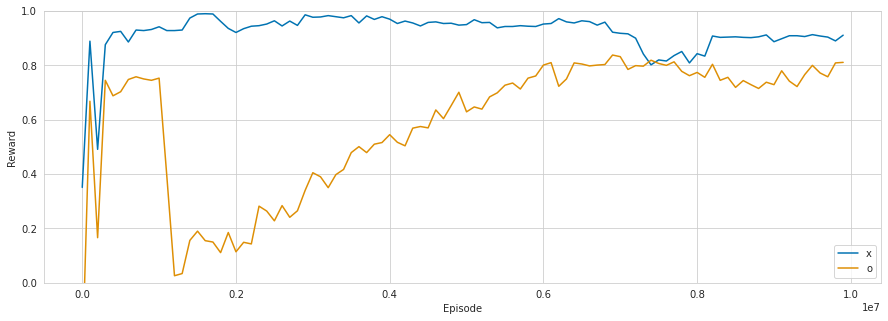

In [92]:
env = TicTacToeEx(3, 3, 3)
env.reset()
root = UCTNodeCached(None, 1, None, env.board, env.getHash(), {})
root = train_mcst_tree(root, env, episode_count = 10_000_000)

**MCTS 4x4**

100%|██████████| 100000000/100000000 [27:00:18<00:00, 2370.89it/s]


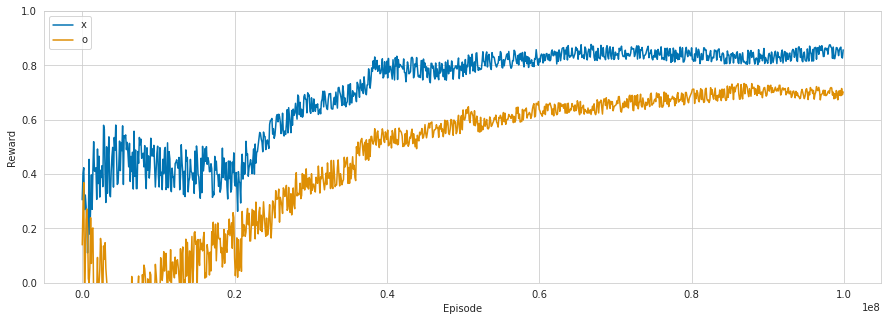

In [111]:
env = TicTacToeEx(4, 4, 4)
env.reset()
root = UCTNodeCached(None, 1, None, env.board, env.getHash(), {})
root = train_mcst_tree(root, env, episode_count = 100_000_000)

Дерево игры 4x4x4 заняло в памяти 40 Гб, поэтому не рискну запустить MCTS для 5х5х5.